In [9]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd
from konlpy.tag import Okt  
okt = Okt() 
import tensorflow as tf
import numpy as np
from collections import Counter
from konlpy.tag import Komoran
komoran = Komoran()
from wordcloud import WordCloud
import matplotlib.pyplot as plt


import urllib.request
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import os
import json

In [10]:
import matplotlib.pyplot as plt 
%matplotlib inline
from string import punctuation
import warnings
warnings.filterwarnings('ignore')

In [12]:
jdf = pd.read_csv('pre_joy_list.csv')

In [13]:
sdf = pd.read_csv('pre_sad_list.csv')

In [14]:
jsdf = sdf.append(jdf)
jsdf.reset_index(inplace=True)
jsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 531 entries, 0 to 530
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   index       531 non-null    int64 
 1   song_id     531 non-null    int64 
 2   song_name   531 non-null    object
 3   artist      531 non-null    object
 4   album       531 non-null    object
 5   Like_Count  531 non-null    object
 6   Lyric       521 non-null    object
 7   cover_url   531 non-null    object
 8   words       531 non-null    object
 9   label       531 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 41.6+ KB


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
train_data, test_data = train_test_split(
  jsdf,
  test_size = 0.25,
  random_state = 5
)

In [17]:
print('훈련 샘플의 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 : 398
테스트 샘플의 개수 : 133


In [18]:
train_data[:5] # 상위 5개 출력

,index,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
186,186,80208612,아름다운 이별 (Song By 옥주현),김형석,김형석 With Friends,"[2,584]",눈물이 흘러 이별인걸 알았어. 힘없이 돌아서던 너의 뒷모습을 바라보며 나만큼 너...,https://image.bugsm.co.kr/album/images/200/801...,"['눈물이', '흘러', '이별인걸', '알았어.', '힘없이', '돌아서던', '...",0
131,131,31867978,처음처럼,엠씨더맥스 (M.C the MAX),CEREMONIA,"[3,358]",눈이 부시게 웃던 널 기억해 이제는 다시 볼 수 없게 됐지만 끝내 붙잡았던 기억...,https://image.bugsm.co.kr/album/images/200/203...,"['눈이', '부시게', '웃던', '널', '기억해', '이제는', '다시', '...",0
140,140,31706106,나만 아픈 일,이해리,나만 아픈 일,"[2,342]",멍하니 또 하루 종일 의미 없는 생각들만 했어 아니라고 아니라고 헤어지자 말하...,https://image.bugsm.co.kr/album/images/200/202...,"['멍하니', '또', '하루', '종일', '의미', '없는', '생각들만', '...",0
285,37,4558347,Oh Boy,Red Velvet (레드벨벳),The Red - The 1st Album,"[6,130]",Oh Boy Oh Boy Oh Boy Oh Boy Oh Boy 날 비춘 햇빛 ...,https://image.bugsm.co.kr/album/images/200/530...,"['Oh', 'Boy', 'Oh', 'Boy', 'Oh', 'Boy', 'Oh', ...",1
507,259,3977739,왼손을 잡고,케이윌,[RE:],[794],매일 보던 넌데 오늘따라 왜이리 떨리니 어제는 생각이 많아서 좀처럼 잠들지...,https://image.bugsm.co.kr/album/images/200/492...,"['매일', '보던', '넌데', '오늘따라', '왜이리', '떨리니', '어제는'...",1


In [19]:
train_data['Lyric'].nunique(), train_data['label'].nunique()

(385, 2)

In [20]:
train_data.drop_duplicates(subset=['Lyric'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

In [21]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 386


<AxesSubplot:>

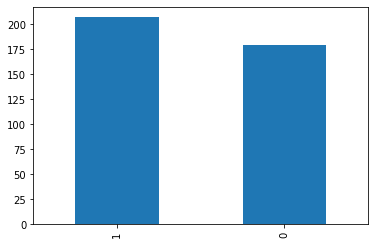

In [22]:
train_data['label'].value_counts().plot(kind = 'bar')

In [25]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0    179
1      1    207


In [26]:
print(train_data.isnull().values.any())

True


In [27]:
print(train_data.isnull().sum())

index         0
song_id       0
song_name     0
artist        0
album         0
Like_Count    0
Lyric         1
cover_url     0
words         0
label         0
dtype: int64


In [28]:
train_data.loc[train_data.Lyric.isnull()]

,index,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
224,224,3877117,"돌이킬 수 없는 걸음 (장화홍련, 메모리즈 OST)",Ttoyo Studio Orchestra,The Good Movie Music,[166],NaN,https://image.bugsm.co.kr/album/images/200/479...,[],0


In [29]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [30]:
print(len(train_data))

385


In [31]:
train_data['Lyric'] = train_data['Lyric'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

,index,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
186,186,80208612,아름다운 이별 (Song By 옥주현),김형석,김형석 With Friends,"[2,584]",눈물이 흘러 이별인걸 알았어 힘없이 돌아서던 너의 뒷모습을 바라보며 나만큼 너도...,https://image.bugsm.co.kr/album/images/200/801...,"['눈물이', '흘러', '이별인걸', '알았어.', '힘없이', '돌아서던', '...",0
131,131,31867978,처음처럼,엠씨더맥스 (M.C the MAX),CEREMONIA,"[3,358]",눈이 부시게 웃던 널 기억해 이제는 다시 볼 수 없게 됐지만 끝내 붙잡았던 기억...,https://image.bugsm.co.kr/album/images/200/203...,"['눈이', '부시게', '웃던', '널', '기억해', '이제는', '다시', '...",0
140,140,31706106,나만 아픈 일,이해리,나만 아픈 일,"[2,342]",멍하니 또 하루 종일 의미 없는 생각들만 했어 아니라고 아니라고 헤어지자 말하...,https://image.bugsm.co.kr/album/images/200/202...,"['멍하니', '또', '하루', '종일', '의미', '없는', '생각들만', '...",0
285,37,4558347,Oh Boy,Red Velvet (레드벨벳),The Red - The 1st Album,"[6,130]",날 비춘 햇빛 모두 네 눈빛 넌 너무 눈이 부셔 ...,https://image.bugsm.co.kr/album/images/200/530...,"['Oh', 'Boy', 'Oh', 'Boy', 'Oh', 'Boy', 'Oh', ...",1
507,259,3977739,왼손을 잡고,케이윌,[RE:],[794],매일 보던 넌데 오늘따라 왜이리 떨리니 어제는 생각이 많아서 좀처럼 잠들지...,https://image.bugsm.co.kr/album/images/200/492...,"['매일', '보던', '넌데', '오늘따라', '왜이리', '떨리니', '어제는'...",1


In [32]:
train_data['Lyric'] = train_data['Lyric'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['Lyric'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

index         0
song_id       0
song_name     0
artist        0
album         0
Like_Count    0
Lyric         4
cover_url     0
words         0
label         0
dtype: int64


In [33]:
train_data[train_data['Lyric'].isnull()]

,index,song_id,song_name,artist,album,Like_Count,Lyric,cover_url,words,label
434,186,5896896,fallin (feat.Liss),죠지,fallin (feat.Liss),[559],NaN,https://image.bugsm.co.kr/album/images/200/978...,"[""Don't"", 'know', 'what', ""I've"", 'been', 'thi...",1
469,221,32338490,xo,G. Nine,xo,[23],NaN,https://image.bugsm.co.kr/album/images/200/204...,"['Er', 'ya', 'this', ""song's"", 'for', 'ya', 'H...",1
425,177,32321750,So In Love (Feat. Filipe Santos),vvav (웨이브),So In Love,[18],NaN,https://image.bugsm.co.kr/album/images/200/204...,"['I', ""don't"", 'know', 'where', 'to', 'start',...",1
225,225,1814881,24-25,Kings Of Convenience(킹스 오브 컨비니언스),Declaration Of Dependence,"[2,637]",NaN,https://image.bugsm.co.kr/album/images/200/201...,"[""She'll"", 'be', 'gone', 'soon', 'You', 'can',...",0


In [34]:
train_data = train_data.dropna(how = 'any')

In [35]:
print(len(train_data))

381


In [36]:
test_data.drop_duplicates(subset = ['Lyric'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['Lyric'] = test_data['Lyric'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['Lyric'] = test_data['Lyric'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['Lyric'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 130


In [37]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 130


In [38]:
stop_w = ['all','이렇게','네가','있는','니가','없는','너의','너무','그런',
          'oh','whoo','tuesday','내가','너를','나를','we','this','the','그렇게',
          'so','am','baby','and','can','you','much','me','for','go','in',
          '은', '는', '이', '가', '하',
          'know','no','of','let','my','사랑','수','너','내','나','그','난','봐','돼','건','모든',
          '날','널','수','것','못','말','넌','젠','하나','정말','알','여기','우리','그대','다시',
          '때','아','더','게','또','채','일','걸','누구','나는','너는','라면','같아','있어','지금',
          '의','가','보','들','좀','잘','걍','과','도','를','으로','우린',
          '자','에','와','한','하다','네','있다','나의','해','다','내게','왜','거야']

In [39]:
stop_w = set(stop_w)

In [40]:
X_train = []
for sentence in tqdm(train_data['Lyric']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 381/381 [00:12<00:00, 31.62it/s]


In [41]:
X_test = []
for sentence in tqdm(test_data['Lyric']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_w] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:02<00:00, 63.65it/s]


In [42]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 130


In [43]:
print("긍정 리뷰 개수: {}".format(train_data['label'].value_counts()[1]))
print("부정 리뷰 개수: {}".format(train_data['label'].value_counts()[0]))

긍정 리뷰 개수: 204
부정 리뷰 개수: 177


In [44]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [45]:
print(tokenizer.word_index)

{'을': 1, '보다': 2, '없다': 3, '않다': 4, '같다': 5, '만': 6, '싶다': 7, '그렇다': 8, '좋다': 9, '사람': 10, '처럼': 11, '내다': 12, '맘': 13, '되다': 14, '마음': 15, '나르다': 16, '모르다': 17, '돼다': 18, '눈': 19, '로': 20, '오늘': 21, '니': 22, '생각': 23, '안': 24, '눈물': 25, '알다': 26, '잊다': 27, '에게': 28, '행복하다': 29, '대다': 30, '아프다': 31, '아니다': 32, '밤': 33, '시간': 34, '곁': 35, '에서': 36, '해주다': 37, '요': 38, '세상': 39, '버리다': 40, '주다': 41, '야': 42, '고': 43, '가다': 44, '오다': 45, '속': 46, '아무': 47, '이제': 48, '함께': 49, '웃다': 50, '하루': 51, '어떻다': 52, '떠나다': 53, '이다': 54, '나다': 55, '거': 56, '만나다': 57, '꿈': 58, '바라보다': 59, '기억': 60, '모습': 61, '엔': 62, '줄': 63, '하고': 64, '기다리다': 65, '자다': 66, '들다': 67, '가슴': 68, '이별': 69, '당신': 70, '마': 71, '괜찮다': 72, '순간': 73, '이렇다': 74, '손': 75, '보고': 76, '혼자': 77, '없이': 78, '다른': 79, '두': 80, '매일': 81, '차다': 82, '만들다': 83, '곳': 84, '까지': 85, '아직': 86, '보내다': 87, '인': 88, '뿐': 89, '처음': 90, '영원하다': 91, '모두': 92, '서': 93, '서로': 94, '추억': 95, '둘': 96, '많다': 97, '조금': 98, '살다': 99, '그때': 100, '받다': 101,

In [46]:
print(tokenizer.word_counts.items())

odict_items([('눈물', 185), ('흐르다', 47), ('이별', 106), ('인걸', 28), ('알다', 184), ('힘없다', 3), ('돌아서다', 26), ('뒷모습', 16), ('을', 1227), ('바라보다', 123), ('만큼', 38), ('슬프다', 75), ('하지만', 47), ('견디다', 41), ('추억', 84), ('아름답다', 67), ('짧다', 15), ('만남', 12), ('로', 209), ('지우다', 71), ('상처', 44), ('뿐', 88), ('인데', 41), ('맘', 259), ('깊다', 33), ('곳', 93), ('엔', 120), ('언제나', 50), ('남기다', 13), ('두다', 74), ('하나로', 13), ('내겐', 53), ('충분하다', 13), ('시간', 166), ('속', 144), ('잊다', 182), ('모두', 85), ('한동안', 6), ('가끔', 58), ('울다', 55), ('같다', 388), ('두', 96), ('눈', 220), ('감고', 12), ('지난날', 11), ('돌아보다', 17), ('숨기다', 12), ('마음속', 10), ('에서', 160), ('느끼다', 56), ('가려진', 2), ('기다', 50), ('에게', 178), ('보고', 101), ('부시', 4), ('웃다', 139), ('기억', 122), ('이제', 143), ('볼', 59), ('없다', 710), ('돼다', 234), ('끝내', 11), ('붙잡다', 20), ('만', 377), ('겨울', 19), ('지나가다', 42), ('나지막이', 1), ('들리다', 15), ('않다', 446), ('전하', 4), ('기다리다', 115), ('한마디', 17), ('대신', 5), ('피고', 7), ('지다', 30), ('뜨겁다', 15), ('시리다', 11), ('보내다', 90), ('계절', 

## 데이터 전처리

In [50]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['Lyric'][0]) 
print(review_text)

구름에 빛은 흐려지고  창가에 요란히 내리는  빗물 소리만큼 시린 기억들이  내 마음 붙잡고 있는데  갈수록 짙어져 간 그리움에 잠겨  시간을 거슬러 갈 순 없나요  그때처럼만 그대 날 안아주면  괜찮을 텐데 이젠  젖어든 빗길을 따라가  함께한 추억을 돌아봐  흐려진 빗물에 떠오른 그대가  내 눈물 속에서 차올라와  갈수록 짙어져 간 그리움에 잠겨  시간을 거슬러 갈 순 없나요  그때처럼만 그대 날 안아주면  괜찮을 텐데 이젠  흩어져 가  나와 있어주던 그 시간도  그 모습도  다시 그때처럼만 그대를 안아서  시간을 거슬러 갈 순 없나요  한 번이라도 마지막일지라도  괜찮을 텐데


In [51]:
okt=Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['구름', '에', '빛', '은', '흐려지다', '창가', '에', '요란하다', '내리다', '빗물', '소리', '만큼', '시리다', '기억', '들', '이', '내', '마음', '붙잡다', '있다', '갈수록', '짙어지다', '간', '그리움', '에', '잠기다', '시간', '을', '거슬러', '갈다', '순', '없다', '그때', '처럼만', '그대', '날', '안다', '괜찮다', '텐데', '이', '젠', '젖다', '빗다', '따라가다', '하다', '추억', '을', '돌아보다', '흐려지다', '빗물', '에', '떠오르다', '그대', '가', '내', '눈물', '속', '에서', '차오르다', '갈수록', '짙어지다', '간', '그리움', '에', '잠기다', '시간', '을', '거슬러', '갈다', '순', '없다', '그때', '처럼만', '그대', '날', '안다', '괜찮다', '텐데', '이', '젠', '흩어지다', '가다', '나오다', '있다', '그', '시간', '도', '그', '모습', '도', '다시', '그때', '처럼만', '그대', '를', '안다', '시간', '을', '거슬러', '갈다', '순', '없다', '하다', '번', '이라도', '마지막', '일지', '라도', '괜찮다', '텐데']


In [52]:
clean_review = [token for token in review_text if not token in stop_w]
print(clean_review)

['구름', '빛', '흐려지다', '창가', '요란하다', '내리다', '빗물', '소리', '만큼', '시리다', '기억', '마음', '붙잡다', '갈수록', '짙어지다', '간', '그리움', '잠기다', '시간', '을', '거슬러', '갈다', '순', '없다', '그때', '처럼만', '안다', '괜찮다', '텐데', '젖다', '빗다', '따라가다', '추억', '을', '돌아보다', '흐려지다', '빗물', '떠오르다', '눈물', '속', '에서', '차오르다', '갈수록', '짙어지다', '간', '그리움', '잠기다', '시간', '을', '거슬러', '갈다', '순', '없다', '그때', '처럼만', '안다', '괜찮다', '텐데', '흩어지다', '가다', '나오다', '시간', '모습', '그때', '처럼만', '안다', '시간', '을', '거슬러', '갈다', '순', '없다', '번', '이라도', '마지막', '일지', '라도', '괜찮다', '텐데']


In [53]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [55]:
okt = Okt()
clean_train_review = []

for review in train_data['Lyric']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_w))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

In [56]:
clean_test_review = []

for review in test_data['Lyric']:
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_w))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가

In [57]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
test_sequences = tokenizer.texts_to_sequences(clean_test_review)

word_vocab = tokenizer.word_index # 단어 사전 형태
word_vocab["<PAD>"] = 0

In [58]:
MAX_SEQUENCE_LENGTH = 525 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 테스트 데이터를 벡터화
test_labels = np.array(test_data['label']) # 테스트 데이터의 라벨

In [60]:
DATA_IN_PATH = './data_in/'
TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
DATA_CONFIGS = 'data_configs.json'

data_configs = {}

data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab) # vocab size 추가

import os
# 저장하는 디렉토리가 존재하지 않으면 생성
if not os.path.exists(DATA_IN_PATH):
    os.makedirs(DATA_IN_PATH)

# 전처리 된 학습 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'wb'), train_inputs)
np.save(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'wb'), train_labels)
# 전처리 된 테스트 데이터를 넘파이 형태로 저장
np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'), test_inputs)
np.save(open(DATA_IN_PATH + TEST_LABEL_DATA, 'wb'), test_labels)

# 데이터 사전을 json 형태로 저장
json.dump(data_configs, open(DATA_IN_PATH + DATA_CONFIGS, 'w'), ensure_ascii=False)

## 시각화 

In [47]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

## 랜덤 시드 고정

In [48]:
### 랜덤 시드 
SEED_NUM = 5
tf.random.set_seed(SEED_NUM)

## 학습 데이터 경로 정의

In [62]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
INPUT_TRAIN_DATA = 'nsmc_train_input.npy'
LABEL_TRAIN_DATA = 'nsmc_train_label.npy'
DATA_CONFIGS = 'data_configs.json'

## 파일 로드

In [63]:
train_input = np.load(open(DATA_IN_PATH + INPUT_TRAIN_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + LABEL_TRAIN_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

## 모델 정의

In [65]:
model_name = 'cnn_classifier_kr'

MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

## 모델 선언 및 컴파일

In [66]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [67]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

## Callback 선언

In [68]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/cnn_classifier_kr -- Folder create complete 



## 모델 학습

In [89]:
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1

In [69]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
1/1 [==============================] - 7s 7s/step - loss: 0.6895 - accuracy: 0.5468 - val_loss: 0.7198 - val_accuracy: 0.4359

Epoch 00001: val_accuracy improved from -inf to 0.43590, saving model to ./data_out/cnn_classifier_kr\weights.h5
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.6933 - accuracy: 0.5468 - val_loss: 0.7073 - val_accuracy: 0.4359

Epoch 00002: val_accuracy did not improve from 0.43590
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.6855 - accuracy: 0.5468 - val_loss: 0.6975 - val_accuracy: 0.4359

Epoch 00003: val_accuracy did not improve from 0.43590


## 결과 플롯

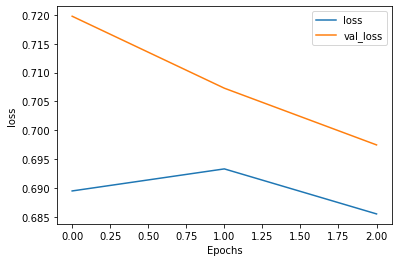

In [70]:
plot_graphs(history, 'loss')

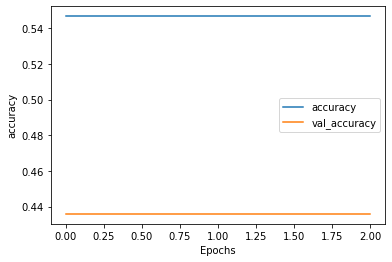

In [71]:
plot_graphs(history, 'accuracy')

## 결과 평가하기

In [72]:
DATA_OUT_PATH = './data_out/'
INPUT_TEST_DATA = 'nsmc_test_input.npy'
LABEL_TEST_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름

test_input = np.load(open(DATA_IN_PATH + INPUT_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_IN_PATH + LABEL_TEST_DATA, 'rb'))

In [73]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [79]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(test_input, test_label_data)[1]))

5/5 [==============================] - 0s 25ms/step - loss: 0.6825 - accuracy: 0.5769

 테스트 정확도: 0.5769


In [82]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_w] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = MAX_SEQUENCE_LENGTH) # 패딩
  score = float(model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 가사입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 가사입니다.\n".format((1 - score) * 100))


In [83]:
sentiment_predict('너를 만난 세상 슬픈 우연 속에서')

54.23% 확률로 긍정 가사입니다.



In [84]:
sentiment_predict('잊혀지지 않는 너의 모습 그리며 우네')

52.59% 확률로 긍정 가사입니다.

